Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import pandas as pd

import tensorflow as tf
import numpy as np
import random
import os


Seed values to keep results constant when changing parameters

In [ ]:
seed_value = 20
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

CNN Model

In [ ]:
class MY_CNN_MODEL():
    def __init__(self, epochs, directory):

        """
        Initializes the convolutional neural network model.

        Args:
            epochs (int): Number of epochs to train the model.
            directory (str): Path to the directory containing the image data.

        Attributes:
            epochs (int): Number of training epochs.
            directory (str): Directory containing training data.
            color (str): Color mode for images, set to grayscale by default.
            image_size (int): Size of the images, set to 256x256.
        """

        self.epochs = epochs
        self.directory = directory
        self.color = 'grayscale'
        self.DATA_SETUP()
        self.IMAGE_PREP()
        self.image_size = 256

    def DATA_SETUP(self):

        """
        Loads the image data from the specified directory and sets it up for training.
        The data is loaded in grayscale mode and batched.
        """

        self.data = tf.keras.utils.image_dataset_from_directory(self.directory, color_mode=self.color,batch_size = 32)

    def IMAGE_PREP(self):

        """
        Prepares the image data by applying data augmentation techniques such as
        random flipping, rotation, picture zoom in and contrast. Also normalizes the pixel values.
        """

        data_augmentation = tf.keras.Sequential([
            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = seed_value),  # Flip the images
            layers.experimental.preprocessing.RandomRotation(0.5, seed = seed_value),  # Rotate the images up to 180 degrees
            layers.experimental.preprocessing.RandomZoom(0.2, seed = seed_value),  # Zoom in/out by 20%
            layers.experimental.preprocessing.RandomContrast(0.2, seed = seed_value),  # Change the contrast by 20%


        ])


        self.data = self.data.map(lambda x, y: (data_augmentation(x, training=True), y))
        self.data = self.data.map(lambda x, y: (x / 255, y))  # Rescale pixel values

        #standard scalar


    def DATA_SPLITS(self, train_size, validation_size, test_size):

        """
        Splits the data into training, validation, and testing datasets.

        Args:
            train_size (float): Proportion of data to be used for training.
            validation_size (float): Proportion of data to be used for validation.
            test_size (float): Proportion of data to be used for testing.
        """
        self.train_size = train_size
        self.validation_size = validation_size
        self.test_size = test_size

        total_size = len(self.data)
        self.train_data = self.data.take(int(total_size * train_size))
        val_test_data = self.data.skip(int(total_size * train_size))
        self.val_data = val_test_data.take(int(total_size * validation_size))
        self.test_data = val_test_data.skip(int(total_size * validation_size))

    def RUN_MODEL(self):

        """
        Builds, compiles, and trains the CNN model using the specified training and validation data.

        The model architecture includes convolutional layers with ReLU activation, max pooling layers,
        dropout layers, and dense layers. It's compiled with the Adam optimizer and binary crossentropy loss.
        Early stopping is employed to prevent overfitting.

        Returns:
            A history object containing the training and validation loss and accuracy for each epoch.
        """

        KERNEL_SIZE = 5
        image_size = 256

        self.model = models.Sequential([
            layers.Conv2D(32, (KERNEL_SIZE, KERNEL_SIZE), activation='relu', input_shape=(image_size, image_size, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.5),
            layers.Conv2D(64, (KERNEL_SIZE, KERNEL_SIZE), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.5),
            layers.Conv2D(64, (KERNEL_SIZE, KERNEL_SIZE), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='sigmoid')

        ])



        from tensorflow.keras.optimizers import Adam

        # Use a different learning rate
        self.model.compile(optimizer=Adam(learning_rate=0.001),  # Change the learning rate here
                           loss='binary_crossentropy',
                           metrics=['accuracy'])


        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            self.train_data,
            validation_data=self.val_data,
            epochs=self.epochs,
            callbacks=[early_stopping]
        )

        self.PLOT_HISTORY(history)
        return history

    def PLOT_HISTORY(self, history):

        """
        Plots the training and validation loss and accuracy over epochs.

        Args:
            history: History object from the training process containing loss and accuracy metrics.

        The method saves a plot showing these metrics as a PNG file.
        """

        max_loss_threshold = 1  # Set a threshold for maximum loss value
        filtered_train_loss = [loss if loss < max_loss_threshold else np.nan for loss in history.history['loss']]
        filtered_val_loss = [loss if loss < max_loss_threshold else np.nan for loss in history.history['val_loss']]

        plt.figure(figsize=(12, 5))

        title_info = f"Epochs: {self.epochs}, Train: {self.train_size}, Val: {self.validation_size}, Test: {self.test_size}"

        plt.subplot(1, 2, 1)
        plt.plot(filtered_train_loss, label='Training Loss')
        plt.plot(filtered_val_loss, label='Validation Loss')
        plt.title(f'Loss Over Epochs - {title_info}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy Over Epochs - {title_info}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
        plt.savefig(f"model_performance_epochs_{self.epochs}_train_{self.train_size}_val_{self.validation_size}_test_{self.test_size}.png")
    def PLOT_CONFUSION_MATRIX(self, data_type):

        """
        Plots a confusion matrix for the specified dataset (training, validation, or testing).

        Args:
            data_type (str): Type of data to plot the confusion matrix for.
                             Must be 'train', 'val', or 'test'.
        """

        if data_type == 'train':
            data = self.train_data
        elif data_type == 'val':
            data = self.val_data
        elif data_type == 'test':
            data = self.test_data
        else:
            raise ValueError("Invalid data_type. Choose 'train', 'val', or 'test'")


        y_true = np.concatenate([y.numpy() for x, y in data])
        y_pred = self.model.predict(data)
        y_pred = np.round(y_pred).reshape(-1)

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)

        plt.title(f'Confusion Matrix - {data_type.capitalize()} Data')
        plt.show()


    def CALCULATE_TEST_ACCURACY(self):

        """
        Calculates and prints the accuracy and loss of the model on the test dataset.
        """

        test_loss, test_accuracy = self.model.evaluate(self.test_data)
        print(f"Test Accuracy: {test_accuracy*100:.2f}%")
        print(f"Test Loss: {test_loss:.4f}")

    def CALCULATE_METRICS(self):

        """
        Calculates and prints various classification metrics like precision, recall, and F1-score for the test dataset.
        """

        test_images, test_labels = zip(*[(x, y) for x, y in self.test_data.unbatch()])
        test_images = np.array(test_images).reshape(-1, 256, 256, 1)
        test_labels = np.array(test_labels)


        y_pred = self.model.predict(test_images)
        y_pred = np.round(y_pred).reshape(-1)


        report = classification_report(test_labels, y_pred)
        print(report)

In [ ]:
DIRECTORY = 'Images'

MODEL INSTANCE #1

In [ ]:
model_instance = MY_CNN_MODEL(epochs=50, directory=DIRECTORY)
model_instance.DATA_SPLITS(train_size=0.6, validation_size=0.2, test_size=0.2)

Found 196 files belonging to 2 classes.


Epoch 1/50
4/4 [==============================] - 22s 5s/step - loss: 1.9359 - accuracy: 0.5234 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 26s 6s/step - loss: 0.6984 - accuracy: 0.4688 - val_loss: 0.6926 - val_accuracy: 0.5312
Epoch 3/50
4/4 [==============================] - 23s 6s/step - loss: 0.6934 - accuracy: 0.5859 - val_loss: 0.6571 - val_accuracy: 0.6875
Epoch 4/50
4/4 [==============================] - 22s 6s/step - loss: 0.6600 - accuracy: 0.6328 - val_loss: 0.6721 - val_accuracy: 0.5625
Epoch 5/50
4/4 [==============================] - 22s 6s/step - loss: 0.7037 - accuracy: 0.6172 - val_loss: 0.7359 - val_accuracy: 0.5938
Epoch 6/50
4/4 [==============================] - 22s 6s/step - loss: 0.6335 - accuracy: 0.6641 - val_loss: 0.6487 - val_accuracy: 0.6562
Epoch 7/50
4/4 [==============================] - 22s 6s/step - loss: 0.6728 - accuracy: 0.5781 - val_loss: 0.6613 - val_accuracy: 0.5938
Epoch 8/50
4/4 [==================

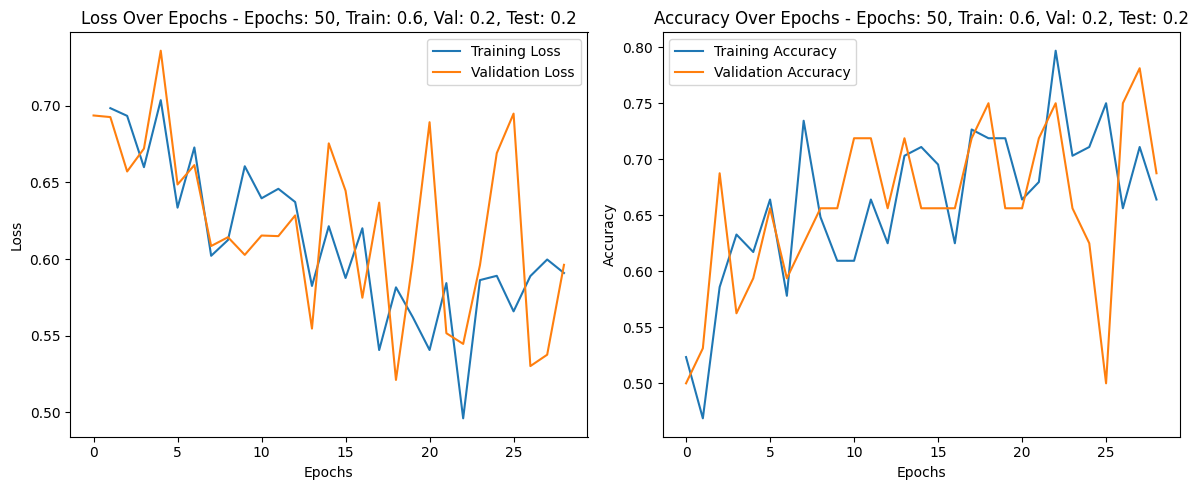

<Figure size 640x480 with 0 Axes>

In [ ]:
history = model_instance.RUN_MODEL()

4/4 [==============================] - 6s 2s/step


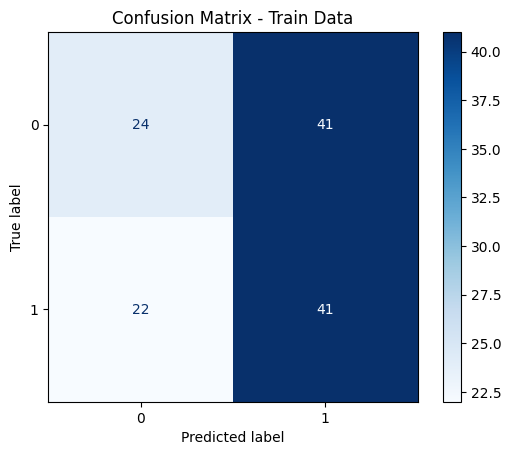

1/1 [==============================] - 2s 2s/step


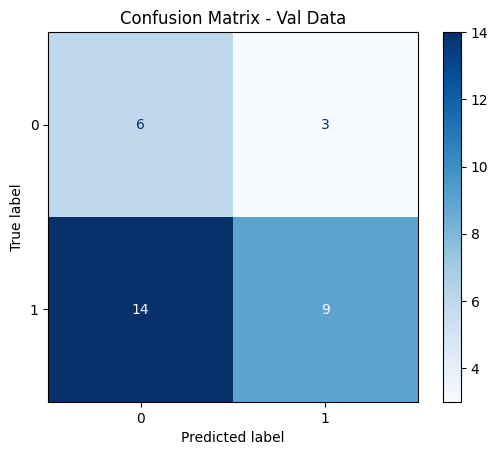

In [ ]:
model_instance.PLOT_CONFUSION_MATRIX('train')  # For training data
model_instance.PLOT_CONFUSION_MATRIX('val')    # For validation data

2/2 [==============================] - 3s 837ms/step


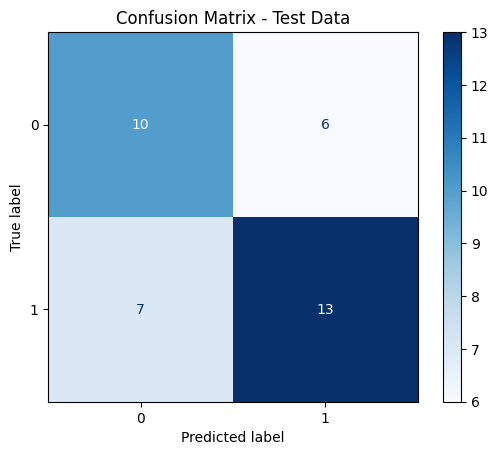

In [ ]:
model_instance.PLOT_CONFUSION_MATRIX('test')    # For validation data

In [ ]:
model_instance.CALCULATE_TEST_ACCURACY()
model_instance.CALCULATE_METRICS()

2/2 [==============================] - 4s 1s/step - loss: 0.4916 - accuracy: 0.8333
Test Accuracy: 83.33%
Test Loss: 0.4916
2/2 [==============================] - 2s 597ms/step
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        24
           1       0.50      0.75      0.60        12

    accuracy                           0.67        36
   macro avg       0.67      0.69      0.66        36
weighted avg       0.72      0.67      0.68        36



MODEL INSTANCE #2

In [ ]:
model_instance2 = MY_CNN_MODEL(epochs=50, directory=DIRECTORY)
model_instance2.DATA_SPLITS(train_size=0.7, validation_size=0.2, test_size=0.1)

Found 196 files belonging to 2 classes.


Epoch 1/50
4/4 [==============================] - 25s 6s/step - loss: 1.9735 - accuracy: 0.4922 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 22s 6s/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.4062
Epoch 3/50
4/4 [==============================] - 21s 5s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5625
Epoch 4/50
4/4 [==============================] - 21s 5s/step - loss: 0.6861 - accuracy: 0.6250 - val_loss: 0.7186 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 22s 6s/step - loss: 0.6822 - accuracy: 0.5312 - val_loss: 0.6530 - val_accuracy: 0.6250
Epoch 6/50
4/4 [==============================] - 22s 6s/step - loss: 0.6737 - accuracy: 0.6016 - val_loss: 0.6219 - val_accuracy: 0.7188
Epoch 7/50
4/4 [==============================] - 21s 5s/step - loss: 0.6867 - accuracy: 0.5312 - val_loss: 0.6879 - val_accuracy: 0.5938
Epoch 8/50
4/4 [==================

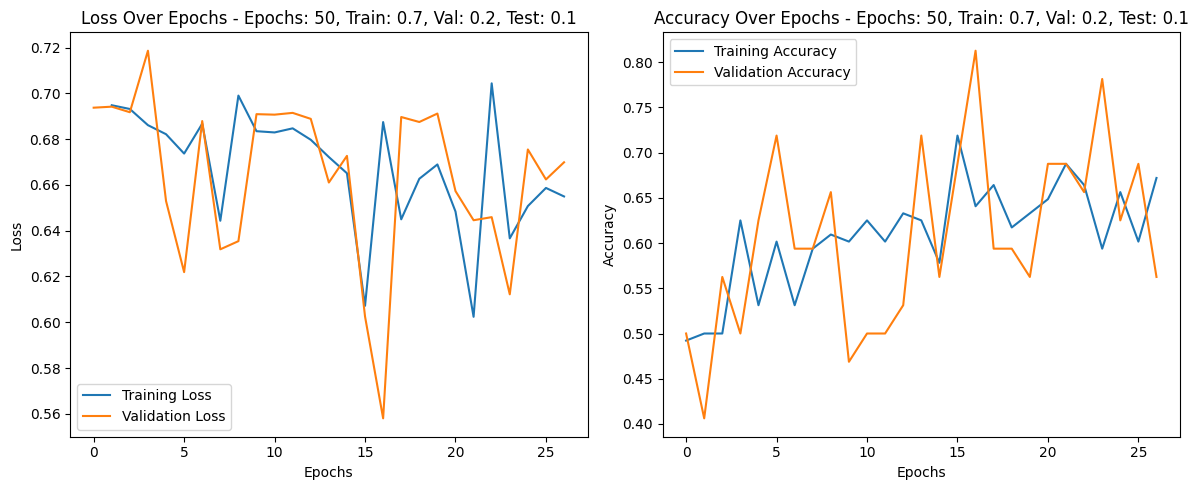

<Figure size 640x480 with 0 Axes>

In [ ]:
history = model_instance2.RUN_MODEL()

4/4 [==============================] - 7s 2s/step


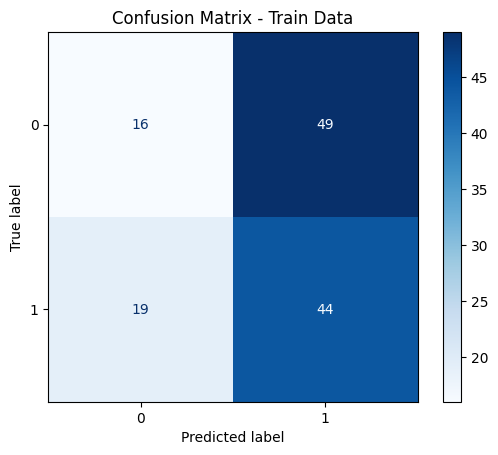

1/1 [==============================] - 2s 2s/step


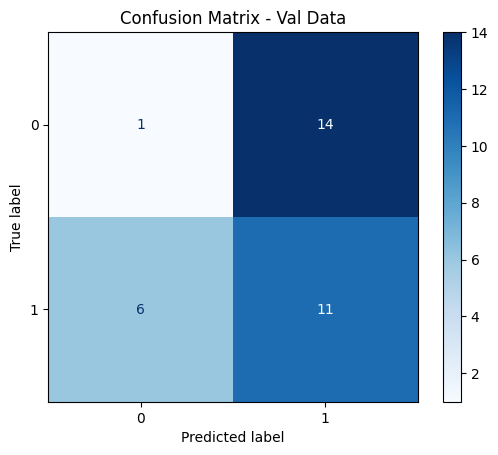

In [ ]:
model_instance2.PLOT_CONFUSION_MATRIX('train')  # For training data
model_instance2.PLOT_CONFUSION_MATRIX('val')    # For validation data

2/2 [==============================] - 3s 738ms/step


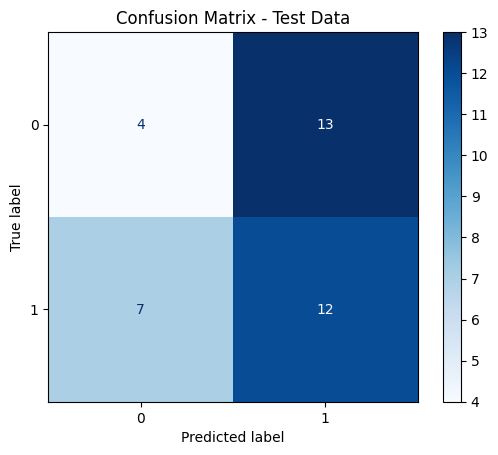

In [ ]:
model_instance2.PLOT_CONFUSION_MATRIX('test')    # For validation data

In [ ]:
model_instance2.CALCULATE_TEST_ACCURACY()
model_instance2.CALCULATE_METRICS()

2/2 [==============================] - 5s 1s/step - loss: 0.6746 - accuracy: 0.5556
Test Accuracy: 55.56%
Test Loss: 0.6746
2/2 [==============================] - 1s 178ms/step
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.75      0.95      0.84        19

    accuracy                           0.81        36
   macro avg       0.83      0.80      0.80        36
weighted avg       0.83      0.81      0.80        36

